In [1]:
%reset -f

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
##read excel
import pandas as pd
data_path = "/content/drive/MyDrive/sales-prediction/sales.xlsx"
df= pd.read_excel(data_path, engine='openpyxl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248646 entries, 0 to 248645
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer ID       246741 non-null  object 
 1   Customer Name     248646 non-null  object 
 2   Shipto Name       246741 non-null  object 
 3   Customer PO #     246741 non-null  object 
 4   Delivery Date     248646 non-null  object 
 5   Invoice Number    246741 non-null  object 
 6   Brand             171451 non-null  object 
 7   Item Description  248646 non-null  object 
 8   Itemcode          248646 non-null  int64  
 9   Packsize          171451 non-null  object 
 10  Quantity          248646 non-null  float64
 11  Total Sales       248646 non-null  float64
 12  G/SG              248646 non-null  object 
 13  Gropup            248646 non-null  object 
 14  Group Desc        248646 non-null  object 
 15  Group Name        248646 non-null  object 
 16  Group Name2       24

In [20]:
## filter data

# Convert 'Delivery Date' to datetime
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], errors='coerce')

df = df.dropna(subset=['Delivery Date'])

# Extract the month and year from 'Delivery Date'
df['YearMonth'] = df['Delivery Date'].dt.to_period('M')

df['Unit Price'] = df['Total Sales'] / df['Quantity']

# Remove trailing whitespace from 'Item Description'
df['Item Description'] = df['Item Description'].str.strip()

df['Customer ID'] = df['Customer ID'].str.strip()

# Extracting unique item codes and descriptions
item_dict = df.drop_duplicates(subset=['Itemcode']).set_index('Itemcode')['Item Description'].to_dict()

# Extracting unique item codes and unit prices
unit_price_dict = df.drop_duplicates(subset=['Itemcode']).set_index('Itemcode')['Unit Price'].to_dict()

In [4]:
# Assuming your DataFrame is named df

# Group by 'YearMonth' and 'Itemcode'
grouped = df.groupby(['YearMonth', 'Itemcode' , 'Customer ID']).agg({
    'Total Sales': 'sum',
}).reset_index()

# Sort the result by 'YearMonth' and 'Itemcode'
grouped = grouped.sort_values(by=['YearMonth', 'Customer ID' ,  'Itemcode'])

# Define the current month
current_month = pd.Period.now('M')

# Filter out the data for the current month
grouped= grouped[grouped['YearMonth'] != current_month]

grouped = grouped[grouped['Customer ID'] != '']

grouped
#810006 is 378269.10 in last

,YearMonth,Itemcode,Customer ID,Total Sales
623,2022-01,110012,0002-000001,140.0
1680,2022-01,210002,0002-000001,19.0
1745,2022-01,310001,0002-000001,19.0
1897,2022-01,310004,0002-000001,17.5
962,2022-01,140011,000210-000001,20956.0
...,...,...,...,...
121657,2024-09,240003,WORLDM-W00006,140.0
121948,2024-09,310003,WORLDM-W00006,22.5
122135,2024-09,310004,WORLDM-W00006,21.5
122309,2024-09,310010,WORLDM-W00006,22.5


In [6]:
import numpy as np


last_period = grouped['YearMonth'].max()

filtered_study = grouped[grouped['YearMonth'] == last_period]


study_items = np.sort(filtered_study['Itemcode'].unique())
study_customers = np.sort(filtered_study['Customer ID'].unique())

grouped = grouped[grouped['Itemcode'].isin(study_items) & grouped['Customer ID'].isin(study_customers)]
# Get all unique periods and item codes

study_periods = grouped['YearMonth'].unique()


# Create a DataFrame with all combinations of periods and item codes
all_combinations = pd.MultiIndex.from_product([study_periods, study_items , study_customers], names=['YearMonth', 'Itemcode' , 'Customer ID']).to_frame(index=False)

# Merge with grouped data, filling missing values with 0 for Quantity and Total Sales
complete_data = pd.merge(all_combinations, grouped, on=['YearMonth', 'Itemcode' , 'Customer ID'], how='left').fillna({'Total Sales': 0})



complete_data = complete_data.sort_values(by=['YearMonth', 'Customer ID' ,  'Itemcode'])

complete_data


,YearMonth,Itemcode,Customer ID,Total Sales
0,2022-01,110001,000210-000001,0.0
475,2022-01,110002,000210-000001,0.0
950,2022-01,110004,000210-000001,0.0
1425,2022-01,110005,000210-000001,0.0
1900,2022-01,110007,000210-000001,0.0
...,...,...,...,...
1879099,2024-09,520012,YESFRE-Y00001,0.0
1879574,2024-09,810002,YESFRE-Y00001,0.0
1880049,2024-09,810006,YESFRE-Y00001,0.0
1880524,2024-09,810010,YESFRE-Y00001,0.0


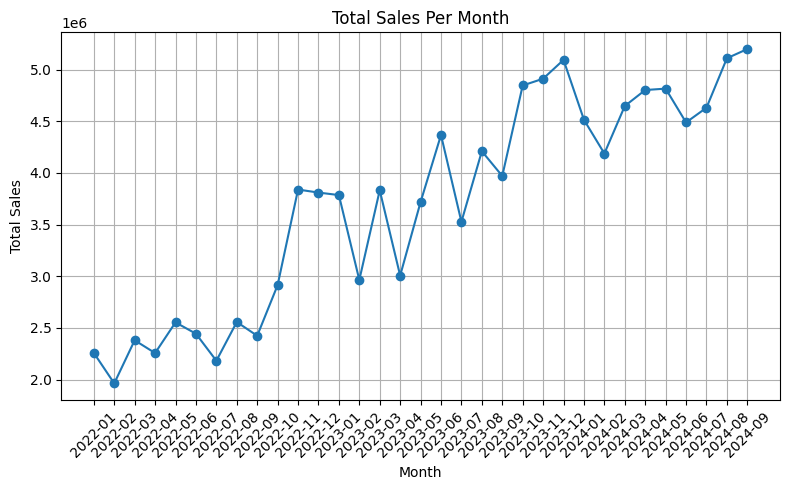

In [7]:
import matplotlib.pyplot as plt

# Group the data by 'YearMonth' and sum the 'Total Sales'
monthly_sales = grouped.groupby('YearMonth')['Total Sales'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(monthly_sales['YearMonth'].astype(str), monthly_sales['Total Sales'], marker='o')

plt.title('Total Sales Per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
# Prepare the DataFrame for the specific item IDs
study_data = complete_data[complete_data['Itemcode'].isin(study_items) & complete_data['Customer ID'].isin(study_customers)]
# Pivot the data to get sales for each item in separate columns


# Pivot the DataFrame
pivoted_df = study_data.pivot_table(index=['YearMonth', 'Customer ID'], columns='Itemcode', values='Total Sales').reset_index()


pivoted_df = pivoted_df.sort_values(by=['YearMonth', 'Customer ID']).drop(columns=["YearMonth" , "Customer ID"])

pivoted_df


Itemcode,110001,110002,110004,110005,110007,110009,110010,110012,110013,110015,...,510011,510018,520001,520002,520005,520012,810002,810006,810010,820013
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,450.0,0.0,0.0,0.0,0.0,3445.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,188.0,0.0,0.0,0.0,51.0,0.0,0.0,675.0,0.0,0.0,...,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15670,1750.0,0.0,0.0,0.0,702.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15671,450.0,0.0,0.0,0.0,216.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15672,950.0,0.0,0.0,0.0,768.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from sklearn.preprocessing import MinMaxScaler


def prepare_data(data , n):
    result = []
    for index in range(0, len(data), n):
        result.append(data[index: index + n])
    return np.array(result)


# Function to create sequences for time series data
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)



# Create sequences
# Scale the data



prepared_data = prepare_data(pivoted_df.values , len(study_customers))



# Define the number of time steps
time_steps = len(prepared_data)//10

X, y = create_sequences(prepared_data, time_steps)

print(X.shape)
print(y.shape)


(30, 3, 475, 120)
(30, 475, 120)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout , Flatten, Reshape, TimeDistributed



# Reshape the input data
X_reshaped = X.reshape(X.shape[0], X.shape[1], -1)

# Define the input shape
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])

# Total size for reshaping should be 475 * 120
total_size =y.shape[1] * y.shape[2]

# Build the model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(total_size, activation='relu'))  # Adjust the Dense layer output size
model.add(Reshape((y.shape[1] , y.shape[2])))  # Ensure the reshape matches the total size

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Assuming you have your reshaped X and y prepared
# X_reshaped.shape should be (30, 3, 57000)
# y.shape should be (30, 475, 120)


# Train the model quietly
model.fit(X_reshaped, y, epochs=100, batch_size=64)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3001895.5000
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2998983.2500   
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2994495.5000   
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2983922.5000   
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2981403.7500
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step - loss: 2975202.5000
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step - loss: 2968193.5000
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 2954779.0000
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 2939758.5000
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2922133.2500
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2909107.2500
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2898700.2500
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2875384.2500
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2842931.0000
Epoch 15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


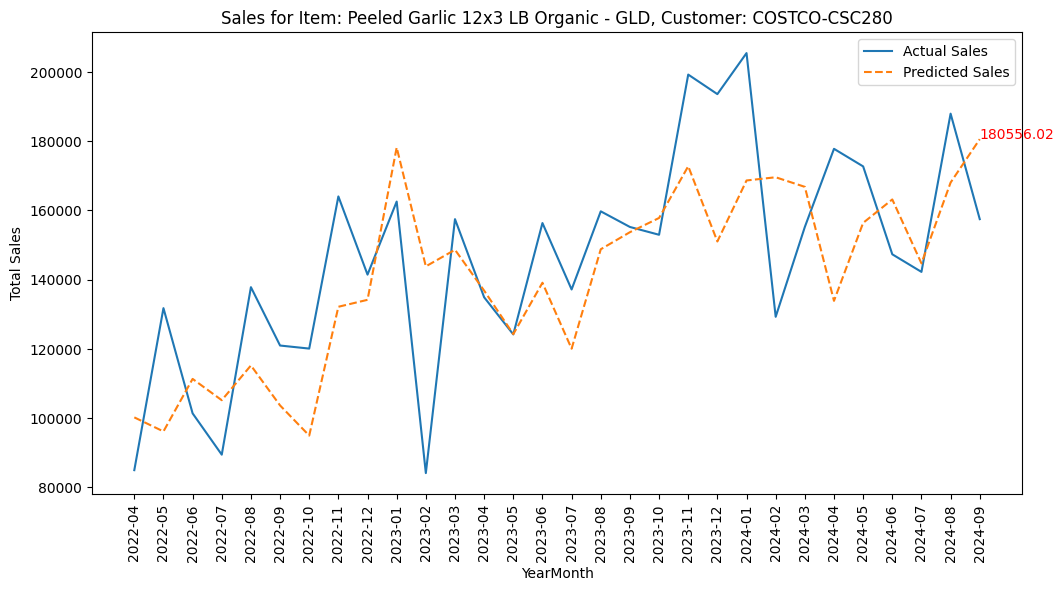

In [23]:
y_pred = model.predict(X_reshaped)





item_id = 110020
customer_id = 'COSTCO-CSC280'

item_index = np.where(study_items == item_id)[0][0]
customer_index = np.where(study_customers == customer_id)[0][0]




predicted_data = y_pred[:,customer_index ,  item_index ]
true_data = y[:,customer_index ,  item_index ]

plot_index = study_periods.astype(str)


# Plot real vs. predicted quantity
plt.figure(figsize=(12, 6))
plt.plot(plot_index[time_steps:], true_data, label='Actual Sales')
plt.plot(plot_index[time_steps:], predicted_data, label='Predicted Sales', linestyle='--')
plt.title(f'Sales for Item: {item_dict[item_id]}, Customer: {customer_id}')
plt.xlabel('YearMonth')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=90)
# Add last prediction value as text annotation
last_pred_value = predicted_data[-1]
plt.text(plot_index[-1], last_pred_value, f'{last_pred_value:.2f}', color='red')
plt.show()

In [76]:
last_X = prepared_data[-time_steps:].reshape(1, time_steps, -1)

last_prediction = model.predict(last_X).reshape(y.shape[1] , y.shape[2])

last_real = y[-1].reshape(y.shape[1] , y.shape[2])

last_train = y_pred[-1].reshape(y.shape[1] , y.shape[2])

last_prediction_df = pd.DataFrame(last_prediction, index=study_customers, columns=study_items).reset_index().melt(id_vars='index', var_name='Item ID', value_name='Predicted Total Sales October').rename(columns={'index': 'Customer ID'})

last_train_df = pd.DataFrame(last_train, index=study_customers, columns=study_items).reset_index().melt(id_vars='index', var_name='Item ID', value_name='Predicted Total Sales September').rename(columns={'index': 'Customer ID'})

# Assuming last_real and last_prediction have the same shape
last_real_df = pd.DataFrame(last_real, index=study_customers, columns=study_items).reset_index().melt(id_vars='index', var_name='Item ID', value_name='Real Sales September').rename(columns={'index': 'Customer ID'})


merged_df = pd.merge(last_prediction_df, last_real_df , on=['Customer ID', 'Item ID'], how='left')


merged_df =  pd.merge(merged_df, last_train_df , on=['Customer ID', 'Item ID'], how='left')




merged_df = merged_df[(merged_df['Predicted Total Sales October'] > 0 ) & (merged_df['Predicted Total Sales September'] > 0)]


# Map the unit prices from the dictionary to a new column
merged_df['Unit Price'] = merged_df['Item ID'].map(unit_price_dict)

# Calculate the quantity
merged_df['Predicted Quantity October'] = merged_df['Predicted Total Sales October'] / merged_df['Unit Price']

merged_df['Real Quantity September'] = merged_df['Real Sales September'] / merged_df['Unit Price']

merged_df['Predicted Quantity September'] = merged_df['Predicted Total Sales September'] / merged_df['Unit Price']

merged_df = merged_df.drop(columns=['Unit Price'])[['Customer ID', 'Item ID','Real Quantity September', 'Real Sales September' , 'Predicted Quantity September' , 'Predicted Total Sales September','Predicted Quantity October', 'Predicted Total Sales October'] ]



merged_df.to_excel('sales-predictions-v1.1.xlsx', index=False)
merged_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


,Customer ID,Item ID,Real Quantity September,Real Sales September,Predicted Quantity September,Predicted Total Sales September,Predicted Quantity October,Predicted Total Sales October
23,BRAVO-000001,110001,93.818182,4644.0,122.848978,6081.024414,100.312441,4965.465820
77,CRBSC-C00007,110001,32.727273,1620.0,45.165922,2235.713135,5.162485,255.543015
80,CSWHSL-000004,110001,45.454545,2250.0,47.901490,2371.123779,17.787366,880.474609
178,KEYFDS-4228,110001,19.191919,950.0,30.927345,1530.903564,21.512683,1064.877808
179,KEYFDS-4230,110001,40.404040,2000.0,20.372345,1008.431091,1.030023,50.986149
...,...,...,...,...,...,...,...,...
56004,WALMAR-000013,810006,1100.000000,28952.0,1214.951647,31977.527344,1185.210495,31194.740234
56005,WALMAR-000015,810006,1983.009119,52192.8,1711.190545,45038.535156,1630.585552,42917.011719
56006,WALMAR-000017,810006,1202.184650,31641.5,1375.280799,36197.390625,1381.295563,36355.699219
56007,WALMAR-DC6099,810006,1416.960486,37294.4,1588.868226,41819.011719,1688.729311,44447.355469
